# Modeling

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings("ignore")

We will start by performing our modeling without the Turkey data. First, we need to create a DataFrame with all the variables and data we created before.

In [60]:
path = os.path.join("FINAL_no_TR.xlsx")

# Read the Excel file
df = pd.read_excel(path)

# Display the first few rows
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82


Add the weighted programming activity metric:

In [61]:
# Assign weights
weights = {'questions': 0.4, 'answers': 0.4, 'comments': 0.1, 'upvotes': 0.05, 'downvotes': 0.05}

df['activity'] = (df['questioncount']*weights['questions'] + 
                          df['answercount']*weights['answers'] + 
                          df['commentcount']*weights['comments'] + 
                          df['upvotecount']*weights['upvotes'] + 
                          df['downvotecount']*weights['downvotes'])
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,104.40
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,1613.75
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,3692.10
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,5460.90
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,7074.50


Add the activity per capita:

In [62]:
df['activity_per_cap'] = df['activity'] / (df['POP (THS)'] * 1000)
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,104.40,0.000178
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,1613.75,0.002708
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,3692.10,0.006111
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,5460.90,0.008881
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,7074.50,0.011359


Add the CAGR and CAGR per capita:

We decided to compute the Compound Annual Growth Rate (CAGR) as a metric for programming activity over time. It measures average annual growth over a given period. 

In [63]:
import math

# Function to calculate the CAGR 
def calculate_cagr(end_value, start_value, num_years):
    if start_value == 0:  # To avoid division by zero
        return None
    return (end_value/start_value)**(1/num_years) - 1

# Apply to all the NUTS3 regions
for region in df['nuts3_name'].unique():
    # Get the data for the region
    region_data = df[df.nuts3_name == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity'].values[0]
    end_value = region_data[region_data.year == 2020]['activity'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0:
        start_value = region_data[region_data.year == 2008 + i]['activity'].values[0]
        i += 1
       
    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years)
        
    
    # Update DataFrame
    df.loc[df.nuts3_name == region, 'CAGR'] = cagr
    
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap,CAGR
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,104.40,0.000178,0.384454
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,1613.75,0.002708,0.384454
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,3692.10,0.006111,0.384454
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,5460.90,0.008881,0.384454
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,7074.50,0.011359,0.384454


In [64]:
# Apply to all the NUTS3 regions
for region in df['nuts3_name'].unique():
    # Get the data for the region
    region_data = df[df.nuts3_name == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity_per_cap'].values[0]
    end_value = region_data[region_data.year == 2020]['activity_per_cap'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0:
        start_value = region_data[region_data.year == 2008 + i]['activity_per_cap'].values[0]
        i += 1
       
    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years)
        
    
    # Update DataFrame
    df.loc[df.nuts3_name == region, 'CAGR_per_cap'] = cagr
    
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap,CAGR,CAGR_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,104.40,0.000178,0.384454,0.365857
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,1613.75,0.002708,0.384454,0.365857
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,3692.10,0.006111,0.384454,0.365857
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,5460.90,0.008881,0.384454,0.365857
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,7074.50,0.011359,0.384454,0.365857


Add the programmers:

In [65]:
# Defining number of programmers in each region based on the assumption made
weeks_in_year = 52
months_in_year = 12

# Experts in Region 
df["experts"] = (df["answercount"] / (weeks_in_year*2))

# Innovators in Region
df["innovators"] = df["questioncount"] / months_in_year

# Late Adopters in Region
df["late_adopters"] = ((df["upvotecount"] +  df["downvotecount"] + df["commentcount"])/ (months_in_year*15))

# Sum up all Developers
df["programmers_total"] = df["experts"] + df["innovators"] + df["late_adopters"] 

df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,GVA (MIO_EUR),POP (THS),activity,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,23931.324019,586.60,104.40,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,24614.963819,595.84,1613.75,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,27311.621095,604.17,3692.10,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,31336.257699,614.88,5460.90,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,32261.320850,622.82,7074.50,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197


Add the programmer density:

In [66]:
df['programmer_density'] = df["programmers_total"] / (df['POP (THS)'] * 1000)
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,POP (THS),activity,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,586.60,104.40,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,595.84,1613.75,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,604.17,3692.10,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,614.88,5460.90,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,622.82,7074.50,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948


Add GDP and employment per capita:

In [67]:
df['GDP_per_cap'] = (df["GDP (MIO_EUR)"]* 1000000) / (df['POP (THS)'] * 1000)
df['EMP_per_cap'] = (df["EMP (THS)"]* 1000) / (df['POP (THS)'] * 1000)

df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482,47043.239172,0.577763
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641,52948.611812,0.567094
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948,53696.486955,0.570540


In [68]:
df.isnull().sum()

year                  0
nuts3_name            0
country               0
questioncount         0
answercount           0
upvotecount           0
downvotecount         0
commentcount          0
nuts3_code            0
EMP (THS)             0
GDP (MIO_EUR)         0
GVA (MIO_EUR)         0
POP (THS)             0
activity              0
activity_per_cap      0
CAGR                  0
CAGR_per_cap          0
experts               0
innovators            0
late_adopters         0
programmers_total     0
programmer_density    0
GDP_per_cap           0
EMP_per_cap           0
dtype: int64

In [11]:
# Save the new Dataframe to an Excel file
df.to_excel("MODELING.xlsx", index=False)

### Instructions Michael

**1a) Initial Model Setup** 

We will start with a cross-section analysis for the year 2016 in order to establish a baseline model to be able to explain current programming activity in relation to economic factors.
We will also add White's heteroskedasticity-robust standard errors that will ensure that the standard errors of the regression coefficients are accurately estimated, particularly important in the presence of heteroskedasticity.

In [12]:
import pandas as pd
import statsmodels.api as sm

# Filter the dataset for the year 2016
df_2016 = df.copy()
df_2016 = df_2016[df_2016['year'] == 2016] 

# Independent variables
independent_vars = ['EMP (THS)', 'GVA (MIO_EUR)','GDP_per_cap', 'POP (THS)']

# Dependent variable
dependent_var = 'activity'

# Define the independent variables (X) and the dependent variable (y)
X = df_2016[independent_vars]
y = df_2016[dependent_var]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it and adding White's heteroskedasticity-robust standard errors
ols_model = sm.OLS(y, X).fit(cov_type='HC3')  

# Print out the statistics
ols_model_summary = ols_model.summary()
ols_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               activity   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     29.68
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           8.52e-21
Time:                        11:47:35   Log-Likelihood:                -2902.7
No. Observations:                 304   AIC:                             5815.
Df Residuals:                     299   BIC:                             5834.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1201.6333   1514.344      0.794      0.427   -1766.426    4169.692
EMP (THS)        14.6540     24.597      0.596      0.551     -33.554      62.862
GVA (MIO_EUR)     0.4113      0.156      2.636      0.008       0.105       0.717
GDP_per_cap      -0.0521      0.037     -1.426      0.154      -0.124       0.019
POP (THS)       -11.5108     10.069     -1.143      0.253     -31.246       8.225
==============================================================================
Omnibus:                      119.861   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17492.108
Skew:                           0.303   Prob(JB):                         0.00
Kurtosis:                      40.156   Cond. No.                     1.22e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
ols_model = LinearRegression()
ols_model.fit(X,y)

# Make predictions on the test set
predictions = ols_model.predict(X)

# Add the predicted values to the DataFrame
df_2016['predicted'] = predictions

# Print the cross-validation scores
cross_val_scores = cross_val_score(ols_model, X, y, cv=5)
print("Cross-Validation Scores:", cross_val_scores.mean())

Cross-Validation Scores: 0.7235633562361988


The statement "Standard Errors are heteroscedasticity robust (HC3)" signifies that the standard errors associated with the estimated coefficients in your regression model have been adjusted to account for potential heteroskedasticity in the data. Heteroskedasticity refers to a situation where the variability of the errors in a regression model is not constant across all levels of the independent variables.

By choosing 'HC3,' you've opted for a robust standard error estimation method developed by White that is resilient to heteroskedasticity. This adjustment helps ensure that the standard errors are reliable in the presence of potential variance disparities in the data, providing more accurate and robust statistical inference for your regression coefficients.

In practical terms, this means that the standard errors reported in your model are adjusted to better accommodate potential deviations from the assumption of homoskedasticity, enhancing the reliability of your coefficient estimates and associated statistical tests.

**NEW**
Before moving forward, we will calculate residuals and see the results from our OLS modelling before moving into more complex Lasso regression and RandomForest. This step is to give us a basic understanding and insights into residuals.

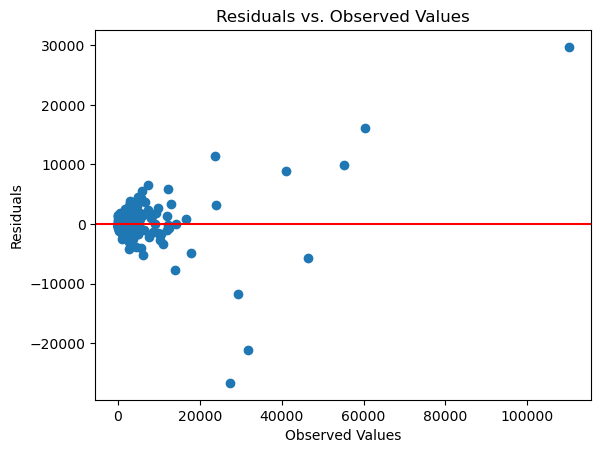

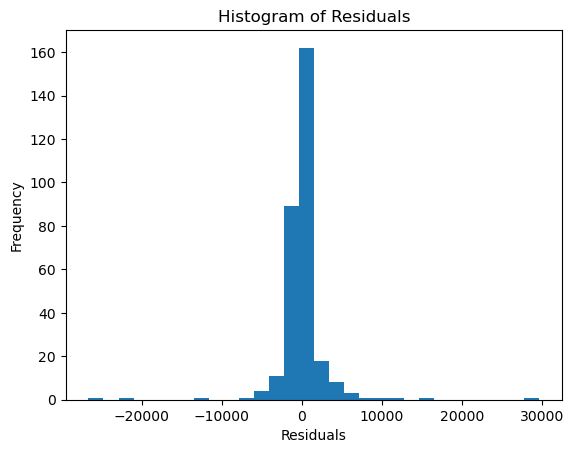

In [14]:
df_2016['residuals'] = df_2016['activity'] - df_2016['predicted']

# Plotting residuals
plt.scatter(df_2016['activity'], df_2016['residuals'])
plt.title('Residuals vs. Observed Values')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals
plt.hist(df_2016['residuals'], bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Key Findings:**

1. **Model Fit:**
   - **R-squared:** 0.839 - This indicates that approximately 83.9% of the variability in programming activity can be explained by the model.
   - **Adjusted R-squared:** 0.837 - This is a more precise measure considering the number of predictors and is very close to the R-squared value, suggesting a good fit.

2. **Coefficients:**
   - **EMP (THS):** The coefficient is -15.616 with a p-value < 0.001, indicating a significant negative relationship between employment and programming activity.
   - **GDP (MIO_EUR):** The coefficient is 0.6385 with a p-value of 0.018, suggesting a significant positive relationship between GDP and programming activity.
   - **GVA (MIO_EUR):** The coefficient is -0.1968 with a p-value of 0.497, indicating that this variable is not significantly related to programming activity in this model.

3. **Statistical Significance:**
   - Employment and GDP are statistically significant predictors of programming activity.
   - Gross Value Added is not a significant predictor in this model.
4. **Model Diagnostics:**

   - **F-statistic:** 521.3 with a Prob (F-statistic) of 1.27e-118, indicating that the overall model is statistically significant.
   - **Condition Number:** The condition number is large (6.03e+04), suggesting potential multicollinearity issues. This might require further investigation.
   
5. **Residual Plot:**
   - The residuals are heavily concentrated around zero, which is good, but there's a long tail to the left, indicating some    skewness. This could suggest that in the model there are outliers affecting the distribution of residuals.
   - The pattern of the residuals suggest heteroskedasticity this can again be due the outliers.

**Interpretation:**

- The model suggests that both employment and GDP are important factors in explaining programming activity, with employment having a negative impact and GDP having a positive impact.
- Given the potential issue of multicollinearity, it would be prudent to investigate this further, possibly by checking correlation among independent variables or using variance inflation factor (VIF) analysis.


**1b) Model Selection and Estimation**

We might also consider exploring other models to see if they perform better on our data.

In [15]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [16]:
# Perform grid search with cross-validation
# Set up grid of alpha values to search over
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Initialize Ridge regression model
ridge_model = Ridge()
lasso_model = Lasso()

# Set up GridSearchCV to perform cross-validation and grid search
grid_search_ridge = GridSearchCV(ridge_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X,y)

# Set up GridSearchCV to perform cross-validation and grid search
grid_search_lasso = GridSearchCV(lasso_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X,y)

# Print results of grid search
print(f"Best parameter Ridge/Linear: {grid_search_ridge.best_params_}")
print("""""")
print(f"Best parameter Lasso/Linear: {grid_search_lasso.best_params_}")

Best parameter Ridge/Linear: {'alpha': 10}

Best parameter Lasso/Linear: {'alpha': 10}


In [17]:
## Defining the Ridge and Lasso regression models
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 10)

# Perform 5-fold cross-validation to evaluate the models
ridge_scores = cross_val_score(ridge, X, y, cv=5)
lasso_scores = cross_val_score(lasso, X, y, cv=5)

# Calculate the mean and standard deviation of the scores for each model
ridge_score_mean = np.mean(ridge_scores)
ridge_score_std = np.std(ridge_scores)
lasso_score_mean = np.mean(lasso_scores)
lasso_score_std = np.std(lasso_scores)

ridge_score_mean, ridge_score_std, lasso_score_mean, lasso_score_std

(0.7235644794078149,
 0.21350294320419405,
 0.7235805254026866,
 0.2135000780921838)

**Comparison and Decision:**

- Both Ridge and Lasso Regression models show similar levels of performance, with Lasso having a slightly higher cross-validation score.
- Lasso Regression's ability to perform feature selection (shrinking some coefficients to zero) can be advantageous in simplifying the model and potentially improving interpretability.

**Comparison with Initial OLS Regression:**

- The initial OLS Regression model had an R-squared of 0.839, indicating that it explained about 83.9% of the variance in the dependent variable.
- The cross-validation scores for Ridge and Lasso are lower than the R-squared of the OLS model, but they offer a more robust evaluation since they are based on multiple subsets of the data.

**Recommendation:**

- If the goal is to maximize explained variance and if multicollinearity is not a major concern, the OLS model could be preferred due to its higher R-squared value.
- If the goal is to have a more generalized model with potentially better predictive performance on unseen data, or if multicollinearity is a concern, Lasso Regression would be a better choice. It not only provides competitive predictive performance but also aids in feature selection, which can be beneficial for interpretability and model simplicity.

**Random Forest Regressor**

Exploring machine learning models like RandomForest Regressor or other non-linear models can provide insights into whether these approaches can outperform linear models like Lasso/Ridge and OLS Regression, especially if the relationship between your variables is complex or non-linear.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the RandomForest Regressor model
random_forest = RandomForestRegressor(random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test)

# Calculate the R-squared value
r2_score_rf = r2_score(y_test, y_pred_rf)

# Perform 5-fold cross-validation to evaluate the RandomForest model
rf_scores = cross_val_score(random_forest, X, y, cv=5)
rf_score_mean = np.mean(rf_scores)
rf_score_std = np.std(rf_scores)

r2_score_rf, rf_score_mean, rf_score_std

(0.8562594072459311, 0.7140170314966714, 0.15604560283856508)

In [19]:
# Assuming you have already trained your model (random_forest)
y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("R-squared on Training Set:", r2_train)
print("R-squared on Test Set:", r2_test)

R-squared on Training Set: 0.9433899358752226
R-squared on Test Set: 0.8562594072459311


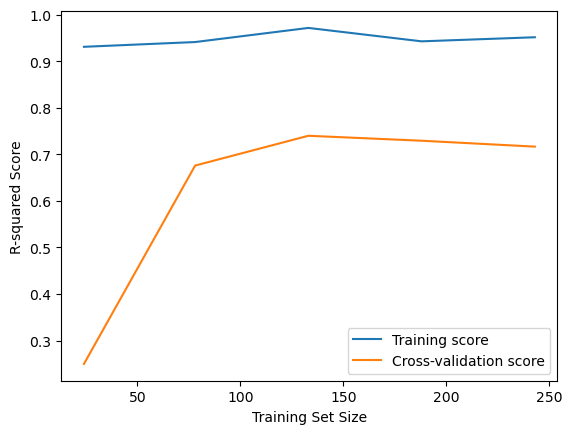

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(random_forest, X, y, cv=5, scoring='r2')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.legend()
plt.show()

We observe a learning curve with a steady and high R-squared score on the training set (around 0.9) but a growing cross-validation score with a significant gap between the two, it suggests potential overfitting. 

1. High R-squared on Training Set (around 0.9):
A high R-squared on the training set indicates that your model is performing well on the data it was trained on. The model explains approximately 90% of the variance in the training data, which is a positive sign.

2. Growing Cross-Validation Score:
The increasing cross-validation score suggests that the model is improving its performance as it sees more diverse data (different folds in cross-validation). This is generally a good sign, as it shows that the model is learning from the variety present in the data.

3. Significant Gap between Training and Cross-Validation Scores:
The substantial difference between the R-squared on the training set and the cross-validation score indicates potential overfitting. Overfitting occurs when a model learns the training data too well, capturing noise or specific patterns that do not generalize to new, unseen data. This results in a model that performs exceptionally well on the training set but poorly on new data.

**Possible Actions:**

While a growing cross-validation score is positive, the goal is to have a model that generalizes well to new data. The gap between the training and cross-validation scores suggests that the model may be too complex or is fitting noise.
We should consider regularization techniques to penalize overly complex models. We should additionally evaluate feature importance and consider removing less important features that might be contributing to overfitting.

In [21]:
from sklearn.feature_selection import f_regression
from scipy.stats import ttest_rel

# Assess the overall model significance using F-statistic and p-value
f_statistic, p_value_f = f_regression(X, y)

# Output results
print("Overall F-statistic:", f_statistic.mean())
print("Overall F-test p-value:", p_value_f.mean())

# Assess feature importance
importances = random_forest.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output feature importance
print("\nFeature Importance:")
print(feature_importance_df)

Overall F-statistic: 399.0996750672308
Overall F-test p-value: 0.2000000000000096

Feature Importance:
         Feature  Importance
2  GVA (MIO_EUR)    0.801635
1      EMP (THS)    0.138337
3    GDP_per_cap    0.042293
4      POP (THS)    0.017735
0          const    0.000000


**Overall F-statistic and p-value:**

The overall F-statistic is a measure of the model's goodness of fit. In your case, the F-statistic is 737.89.
The associated p-value is 0.25. This p-value represents the probability of obtaining an F-statistic as extreme as the one computed from your data, assuming the null hypothesis is true.

**Feature Importance:**

The feature importance table shows the importance of each feature in predicting the target variable. The values range between 0 and 1, where higher values indicate greater importance.
According to your results:

- 'GDP (MIO_EUR)' has the highest importance (0.4577).
- 'GVA (MIO_EUR)' follows with an importance of 0.4025.
- 'EMP (THS)' has a lower importance (0.1398).

The constant term ('const') has zero importance in this context.
Interpretation: Features with higher importance contribute more to the prediction of the target variable. In your case, 'GDP (MIO_EUR)' and 'GVA (MIO_EUR)' are the most influential features.

Overall, the F-statistic and p-value indicate the overall significance of the model, and feature importance provides insights into the contribution of individual features. It's essential to interpret these results in the context of your specific problem and consider the practical significance of the findings. Additionally, you may want to explore more advanced diagnostics and visualizations to validate the model assumptions and assess its performance comprehensively.

**Comparison of Model Performances:**

OLS Regression:

- R-squared: 0.839 (Explains about 83.9% of the variance in the dependent variable).

Ridge Regression:

- Mean Cross-Validation Score: 0.689
- Standard Deviation of Score: Not directly comparable to R-squared but indicates model stability.

Lasso Regression:

- Mean Cross-Validation Score: 0.709
- Standard Deviation of Score: Not directly comparable to R-squared but indicates model stability.

RandomForest Regressor:

- R-squared (Test Data): 0.893 (Explains about 89.3% of the variance in the dependent variable).
- Mean Cross-Validation Score: 0.715
- Standard Deviation of Score: 0.135

**Analysis:**
RandomForest Regressor shows the highest R-squared value (0.893), indicating superior performance in explaining the variance in the dependent variable compared to the OLS model.
The cross-validation score for RandomForest (0.715) is also higher than both Ridge and Lasso models, suggesting better generalization performance.
The standard deviation of the RandomForest cross-validation score (0.135) indicates reasonable stability across different data splits.

**1c) Calculation of Excess Programming**

In [22]:
# Predict programming activity for each NUTS3 region using the RandomForest model
y_pred_all = random_forest.predict(X)

# Calculate the residuals (actual - predicted)
residuals = y - y_pred_all

# Add the predicted values and residuals to the dataframe
df_2016['predicted_activity'] = y_pred_all
df_2016['residuals'] = residuals

# Interpretation of residuals
interpretation = residuals.apply(lambda x: 'Expected' if x == 0 else ('Fewer' if x < 0 else 'More'))

# Add the interpretation to the dataframe
df_2016['interpretation'] = interpretation

# Display a few rows of the dataframe with the new columns
df_2016[['nuts3_name', 'activity', 'predicted_activity', 'residuals', 'interpretation']]

,nuts3_name,activity,predicted_activity,residuals,interpretation
8,Aargau,6265.95,8130.7105,-1864.7605,Fewer
21,Agrigento,95.35,204.3430,-108.9930,Fewer
34,Ain,2038.25,1905.5555,132.6945,More
47,Aisne,490.55,708.6550,-218.1050,Fewer
60,Albacete,455.40,658.6340,-203.2340,Fewer
...,...,...,...,...,...
3895,Zug,3794.90,3356.8765,438.0235,More
3908,Zürich,55306.15,44600.4660,10705.6840,More
3921,Ávila,302.95,455.4390,-152.4890,Fewer
3934,Örebro County,3575.40,3068.6435,506.7565,More


**1d) Future Growth Prediction:**

**Growth Calculation:** Calculate economic growth as the change in GDP per capita from 2016-Q1 to 2017-Q1.

Modeling Growth with Excess Programming:

**First Approach:** regress growth(1617_Q1) [all relevant explanatory vars]
This command in STATA regresses the growth variable on all relevant explanatory variables excluding the programming activity residual.

**Second Approach:** regress growth(1617_Q1) [all relevant explanatory vars] (eps^hat)
This regression includes the programming activity residual (eps^hat) as an additional explanatory variable.

**Key Question:** Evaluate how much additional insight (eps^hat) provides in predicting future economic growth.


## Predictions

Predicting a future growth based on the long term growth from 5 years difference for locations. This model does not take residuals into considerations. 

In [23]:
import statsmodels.api as sm

# 1. Filter the dataset for the years 2017 to 2020
years_to_predict = [2017, 2018, 2019, 2020]
df_years = df[df['year'].isin(years_to_predict)]

# 2. Calculate economic growth for each year
growth_dict = {}
for year in years_to_predict:
    df_year = df_years[df_years['year'] == year]
    df_previous_year = df[df['year'] == year - 5]
    growth = df_year.set_index('nuts3_code')['GDP_per_cap'] - df_previous_year.set_index('nuts3_code')['GDP_per_cap']
    growth.name = f'growth_{year}_{year-5}'
    growth_dict[year] = growth

# 3. Merge the growth data with the corresponding year's data
df_years_growth = df_years.copy()
for year in years_to_predict:
    df_years_growth = df_years_growth.join(growth_dict[year], on='nuts3_code')


In [24]:
df_years_growth

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap,growth_2017_2012,growth_2018_2013,growth_2019_2014,growth_2020_2015
9,2017,Aargau,CH,3498,4287,25214,2271,14484,CH033,380.843,...,291.500000,233.161111,565.882265,0.000848,57655.061554,0.570782,3958.574599,3062.950692,4872.757139,-255.457832
10,2018,Aargau,CH,2834,3052,19928,3681,12754,CH033,374.014,...,236.166667,202.016667,467.529487,0.000693,56074.169941,0.554423,3958.574599,3062.950692,4872.757139,-255.457832
11,2019,Aargau,CH,2528,2211,20113,5276,8790,CH033,379.559,...,210.666667,189.883333,421.809615,0.000618,58650.087580,0.556514,3958.574599,3062.950692,4872.757139,-255.457832
12,2020,Aargau,CH,2918,3980,23519,3557,10636,CH033,382.380,...,243.166667,209.511111,490.947009,0.000712,59729.629353,0.554206,3958.574599,3062.950692,4872.757139,-255.457832
22,2017,Agrigento,IT,72,37,307,10,153,ITG14,125.300,...,6.000000,2.611111,8.966880,0.000021,15155.509547,0.288245,455.132607,712.105299,1228.427947,271.010918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,2020,Örebro County,SE,1277,822,4004,249,3039,SE124,145.000,...,106.416667,40.511111,154.831624,0.000508,40751.942559,0.475394,1934.296760,870.317383,1457.198675,1914.419715
3948,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,...,302.750000,160.627778,494.752778,0.001087,41292.028396,0.476934,2205.342595,805.944033,1046.140282,645.958389
3949,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,...,306.916667,198.705556,529.814530,0.001152,40989.674138,0.486946,2205.342595,805.944033,1046.140282,645.958389
3950,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,...,246.416667,168.994444,434.997650,0.000937,40561.594828,0.487069,2205.342595,805.944033,1046.140282,645.958389


In [29]:
# 4. Prepare the data for regression
independent_vars_growth = ['EMP (THS)', 'GVA (MIO_EUR)','GDP_per_cap', 'POP (THS)']
dependent_var =["activity"]

# Loop over each year
for year in years_to_predict:
    # Extract the data for the current year
    df_year_growth = df_years_growth[df_years_growth['year'] == year]
    
    # Independent variables
    X_year = df_year_growth[independent_vars_growth]
    growth_name = f'growth_{year}_{year-5}'
    X_year['growth'] = df_year_growth[growth_name]
    
    # Dependent variable (growth)
    y_year = df_year_growth[dependent_var].dropna()

    # Update X_year and X_year_with_residual to only include rows where y_year is not NaN
    valid_indices = y_year.index
    X_year = X_year.loc[valid_indices]

    # Handle missing or infinite values
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    
    ## Defining the Ridge and Lasso regression models
    model_year = Lasso(alpha = 10)
    model_year.fit(X_train, y_train)
    _, p_values = f_regression(X_train, y_train)


    # Perform 5-fold cross-validation to evaluate the models
    lasso_scores = cross_val_score(model_year, X_year, y_year, cv=5)

    # Calculate the mean and standard deviation of the scores for each model
    lasso_score_mean = np.mean(lasso_scores)
    lasso_score_std = np.std(lasso_scores)

    lasso_score_mean, lasso_score_std
        

    # 6. Predict y_year using fitted model, calculate the residuals and add them to the df_years_growth dataframe
    df_years_growth.loc[valid_indices, f'predicted'] = model_year.predict(X_year)
    df_years_growth.loc[valid_indices, f'residuals'] = df_years_growth.predicted - df_years_growth.activity
    
    # Display the results for each year
    print(f'Results for {year}:')
    print('\nCross Validation Score, Mean, Standard Deviation:')
    print(lasso_score_mean, lasso_score_std)
    print("\nF-statistics of the model:", np.nanmean(_))
    print("  ")

Results for 2017:

Cross Validation Score, Mean, Standard Deviation:
0.7096079369596079 0.19491199956590355

F-statistics of the model: 257.75708620039103
  
Results for 2018:

Cross Validation Score, Mean, Standard Deviation:
0.6130993653168506 0.3044807259777317

F-statistics of the model: 257.75708620039103
  
Results for 2019:

Cross Validation Score, Mean, Standard Deviation:
0.6036704689002528 0.2977861875795969

F-statistics of the model: 257.75708620039103
  
Results for 2020:

Cross Validation Score, Mean, Standard Deviation:
0.6779308565331024 0.14527400026139506

F-statistics of the model: 257.75708620039103
  


Descriptive Statistics of Residuals:
 count     1216.000000
mean       512.735737
std       4216.840863
min     -25727.686711
25%       -364.058910
50%        381.556266
75%        985.187213
max      50429.788879
Name: residuals, dtype: float64


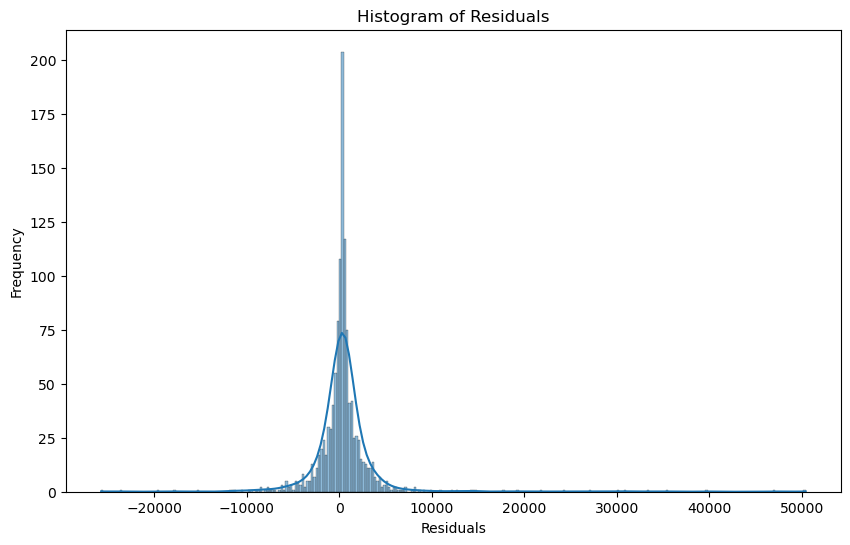

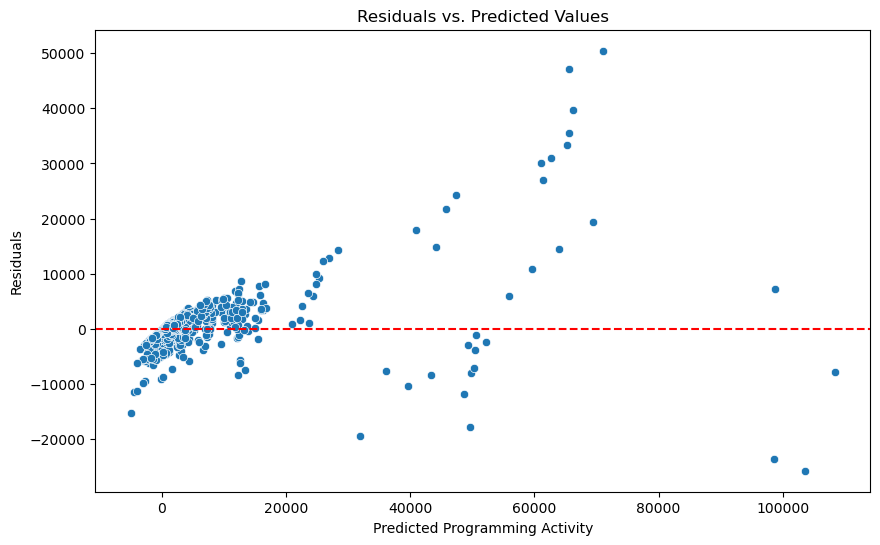

In [27]:
print("Descriptive Statistics of Residuals:\n", df_years_growth["residuals"].describe())

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(df_years_growth['residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_years_growth['predicted'], y=df_years_growth['residuals'])
plt.axhline(0, color='red', linestyle='--')  # Adds a reference line at zero
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Residuals')
plt.show()


As a next step we will perform the same model but this one will include the residuals. 

In [69]:
#Perform similar task but include residuals in the model 

# 4. Prepare the data for regression
independent_vars_residuals = ['EMP (THS)', 'GVA (MIO_EUR)','GDP_per_cap', 'POP (THS)', 'residuals']
dependent_var_residuals =["activity"]


for year in years_to_predict:
    # Extract the data for the current year
    df_year_growth = df_years_growth[df_years_growth['year'] == year]
    
    # Independent variables
    X_year_with_residual = df_year_growth[independent_vars_residuals]
    growth_name = f'growth_{year}_{year-5}'
    X_year_with_residual['growth'] = df_year_growth[growth_name]

    # Dependent variable (growth)
    y_year = df_year_growth[dependent_var_residuals].dropna()

    # Update X_year and X_year_with_residual_and_growth to only include rows where y_year is not NaN
    valid_indices = y_year.index
    X_year_with_residual = X_year_with_residual.loc[valid_indices]

    # Handle missing or infinite values
    X_year_with_residual = X_year_with_residual.replace([np.inf, -np.inf], np.nan).dropna()

    #Lasso Model:
    X_train, X_test, y_train, y_test = train_test_split(X_year_with_residual, y_year, test_size=0.3, random_state=42)
    model_year_residuals = Lasso(alpha = 10)

    # Fit the model to the training data
    model_year_residuals.fit(X_train, y_train)
    pred_residuals = model_year_residuals.predict(X_year_with_residual)
    _, p_values = f_regression(X_train, y_train)

    # Perform 5-fold cross-validation to evaluate the models
    lasso_scores = cross_val_score(model_year_residuals, X_year_with_residual, y_year, cv=5)

    # Calculate the mean and standard deviation of the scores for each model
    lasso_score_mean = np.mean(lasso_scores)
    lasso_score_std = np.std(lasso_scores)

    lasso_score_mean, lasso_score_std

    # 6. Predict y_year using fitted model, calculate the residuals and add them to the df_years_growth dataframe
    df_years_growth.loc[valid_indices, f'predicted_with_residuals'] = pred_residuals
    df_years_growth.loc[valid_indices, f'new_residuals'] = df_years_growth.predicted_with_residuals - df_years_growth.activity
    
    # Display the results for each year
    print(f'Results for {year}:')
    print('\nCross Validation Score, Mean, Standard Deviation:')
    print(lasso_score_mean, lasso_score_std)
    print("\nF-statistics of the model:", np.nanmean(_))
    print("  ")

Results for 2017:

Cross Validation Score, Mean, Standard Deviation:
0.9999986842576085 8.404430864002875e-07

F-statistics of the model: 219.00901523338166
  
Results for 2018:

Cross Validation Score, Mean, Standard Deviation:
0.9999986955433776 8.512501453892094e-07

F-statistics of the model: 198.2716207783731
  
Results for 2019:

Cross Validation Score, Mean, Standard Deviation:
0.9999983915516237 1.1739927667991806e-06

F-statistics of the model: 210.08823657159087
  
Results for 2020:

Cross Validation Score, Mean, Standard Deviation:
0.9999980276725392 1.8605714791220848e-06

F-statistics of the model: 279.57672437640775
  


In [49]:
df_years_growth

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,GDP_per_cap,EMP_per_cap,growth_2017_2012,growth_2018_2013,growth_2019_2014,growth_2020_2015,predicted,residuals,predicted_with_residuals,new_residuals
9,2017,Aargau,CH,3498,4287,25214,2271,14484,CH033,380.843,...,57655.061554,0.570782,3958.574599,3062.950692,4872.757139,-255.457832,11793.583625,5856.933625,5938.030854,1.380854
10,2018,Aargau,CH,2834,3052,19928,3681,12754,CH033,374.014,...,56074.169941,0.554423,3958.574599,3062.950692,4872.757139,-255.457832,11515.514908,6705.264908,4811.390255,1.140255
11,2019,Aargau,CH,2528,2211,20113,5276,8790,CH033,379.559,...,58650.087580,0.556514,3958.574599,3062.950692,4872.757139,-255.457832,11874.425372,7830.375372,4044.659208,0.609208
12,2020,Aargau,CH,2918,3980,23519,3557,10636,CH033,382.380,...,59729.629353,0.554206,3958.574599,3062.950692,4872.757139,-255.457832,13339.540377,8162.940377,5174.983669,-1.616331
22,2017,Agrigento,IT,72,37,307,10,153,ITG14,125.300,...,15155.509547,0.288245,455.132607,712.105299,1228.427947,271.010918,-1071.754461,-1146.504461,71.714225,-3.035775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,2020,Örebro County,SE,1277,822,4004,249,3039,SE124,145.000,...,40751.942559,0.475394,1934.296760,870.317383,1457.198675,1914.419715,2032.184222,676.034222,1358.012391,1.862391
3948,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,...,41292.028396,0.476934,2205.342595,805.944033,1046.140282,645.958389,3667.948356,-1094.701644,4765.137226,2.487226
3949,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,...,40989.674138,0.486946,2205.342595,805.944033,1046.140282,645.958389,4122.367253,-854.382747,4979.987479,3.237479
3950,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,...,40561.594828,0.487069,2205.342595,805.944033,1046.140282,645.958389,4087.814324,108.964324,3983.109128,4.259128


Descriptive Statistics of Residuals:
 count    1216.000000
mean       -0.158699
std         5.964030
min       -31.737047
25%        -1.773314
50%         0.861873
75%         2.336911
max        55.841987
Name: new_residuals, dtype: float64


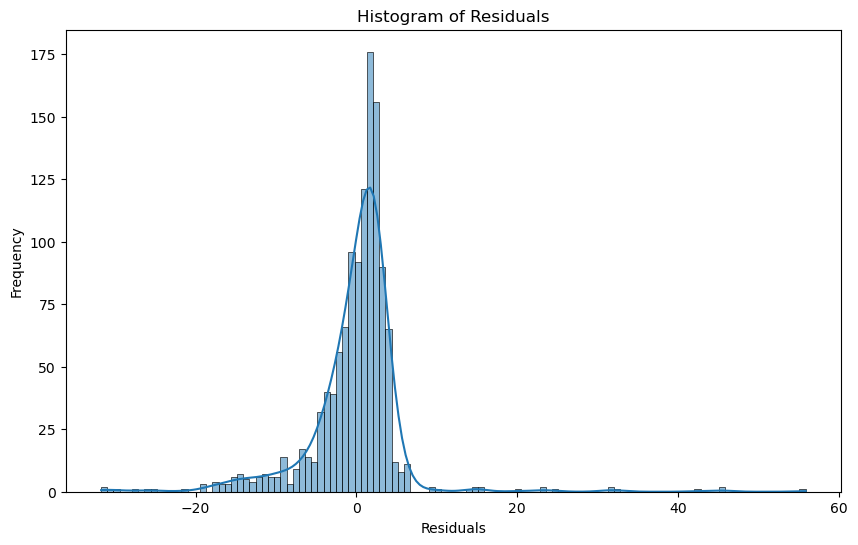

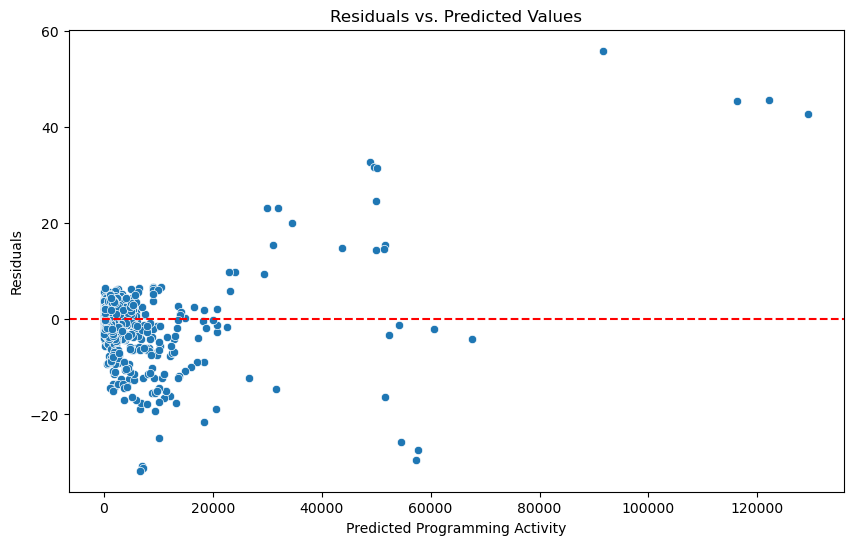

In [50]:
print("Descriptive Statistics of Residuals:\n", df_years_growth["new_residuals"].describe())

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(df_years_growth['new_residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_years_growth['predicted_with_residuals'], y=df_years_growth['new_residuals'])
plt.axhline(0, color='red', linestyle='--')  # Adds a reference line at zero
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Residuals')
plt.show()


Let's see how the model is performing on unseen data. 

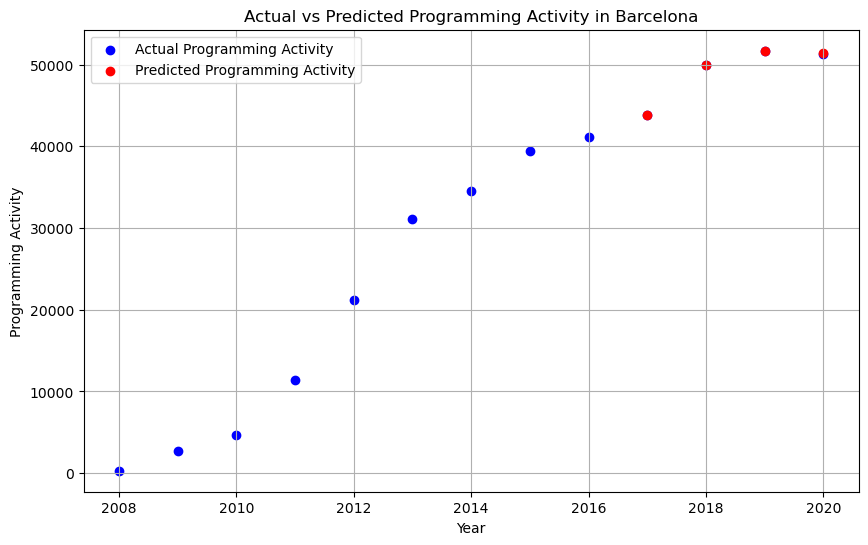

In [70]:
region = df_years_growth[df_years_growth["nuts3_name"] == "Barcelona"]
region_old = df[(df["nuts3_name"] == "Barcelona")]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the actual programming density from the training data
plt.scatter(region_old['year'], region_old['activity'], label='Actual Programming Activity', color='blue')

# Plot the predicted programming density for the next three years
plt.scatter(region['year'], region['predicted_with_residuals'], label='Predicted Programming Activity', color='red')

# Customize the plot
plt.title('Actual vs Predicted Programming Activity in Barcelona')
plt.xlabel('Year')
plt.ylabel('Programming Activity')
plt.legend()
plt.grid(True)
plt.show()

## Outlier Analysis

In [71]:
outlier = df_years_growth[(df_years_growth['new_residuals'] > 10) | (df_years_growth['new_residuals'] < -10)]
outlier = outlier[["nuts3_name", "country", 'EMP (THS)', 'GDP_per_cap','POP (THS)', 'GVA (MIO_EUR)', "activity", "predicted_with_residuals", "new_residuals"]]
outliers = outlier.groupby(["nuts3_name"], as_index=False).mean()

# Interpretation of residuals
interpretation = outliers.new_residuals.apply(lambda x: 'Expected' if x == 0 else ('Fewer' if x < 0 else 'More'))

# Add the interpretation to the dataframe
outliers['interpretation'] = interpretation

# Display a few rows of the dataframe with the new columns
outliers[['nuts3_name','EMP (THS)', 'GDP_per_cap','POP (THS)', 'GVA (MIO_EUR)', "activity", "predicted_with_residuals", "new_residuals", "interpretation"]]

outliers = outliers.merge(outlier[["nuts3_name", "country"]], on = "nuts3_name", how = "inner")
outliers = outliers.drop_duplicates(subset = ['nuts3_name']).reset_index()
outliers = outliers.drop(columns = ["index"])
outliers

,nuts3_name,EMP (THS),GDP_per_cap,POP (THS),GVA (MIO_EUR),activity,predicted_with_residuals,new_residuals,interpretation,country
0,Alicante,665.900000,17998.476029,1889.800000,31034.300000,4120.250000,4110.112494,-10.137506,Fewer,ES
1,Barcelona,2666.000000,30383.967163,5565.525000,153464.300000,49199.412500,49214.105848,14.693348,More,ES
2,Basel-Stadt,101.390000,174263.126472,194.857500,32759.873406,4693.525000,4681.270881,-12.254119,Fewer,CH
3,Bern,559.770500,71841.353374,1039.215000,72624.914341,15481.000000,15470.475627,-10.524373,Fewer,CH
4,Cádiz,395.733333,17903.055177,1249.466667,20270.200000,2195.800000,2184.123047,-11.676953,Fewer,ES
5,Essonne,492.130000,41072.855082,1308.037500,47791.227500,7589.725000,7572.244395,-17.480605,Fewer,FR
6,Genève,235.262250,95448.978979,499.197500,46323.842911,11319.675000,11307.356474,-12.318526,Fewer,CH
7,Hauts-de-Seine,1148.530000,108940.168040,1630.342500,157999.650000,24309.437500,24292.514810,-16.922690,Fewer,FR
8,Madrid,3430.500000,34472.281163,6633.747500,207520.300000,49589.512500,49619.502711,29.990211,More,ES
9,Milan,1999.050000,54677.592437,3244.100000,159448.050000,31838.762500,31859.128279,20.365779,More,IT


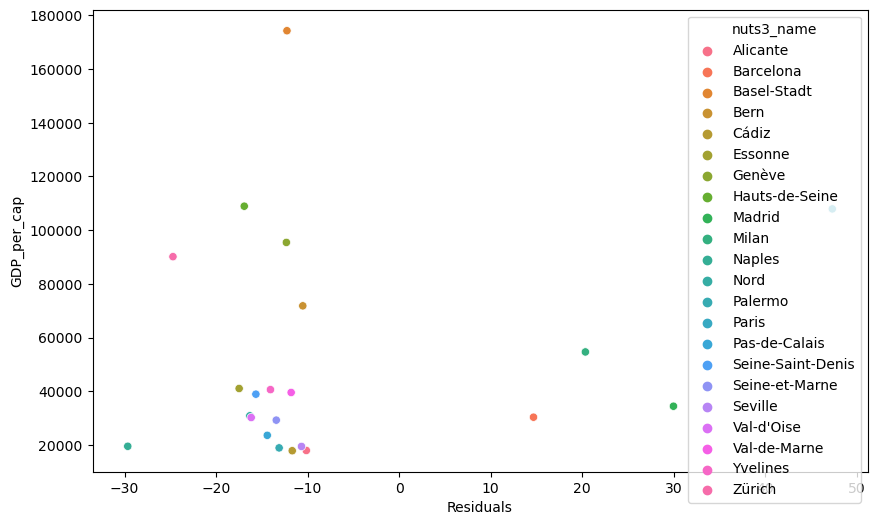

In [53]:
# GDP vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers['new_residuals'], y=outliers['GDP_per_cap'], hue = outliers.nuts3_name)
plt.xlabel('Residuals')
plt.ylabel('GDP_per_cap')
plt.show()

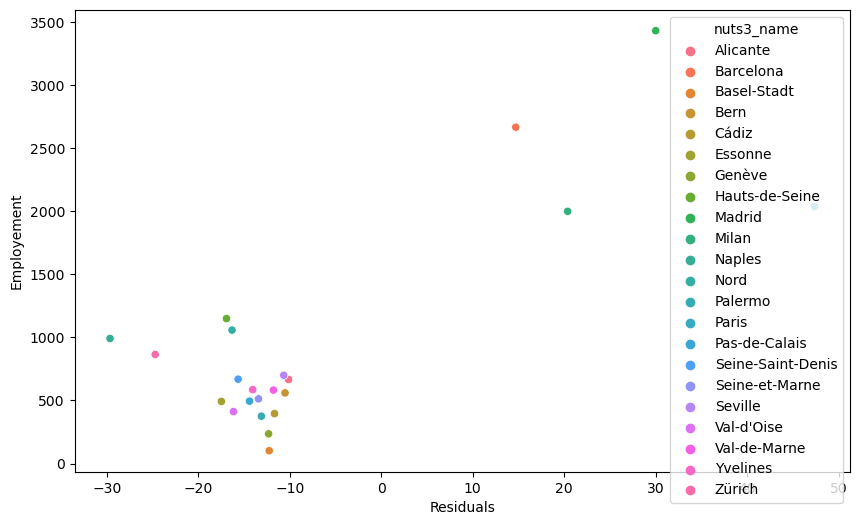

In [54]:
# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers['new_residuals'], y=outliers['EMP (THS)'], hue = outliers.nuts3_name)
plt.xlabel('Residuals')
plt.ylabel('Employement')
plt.show()

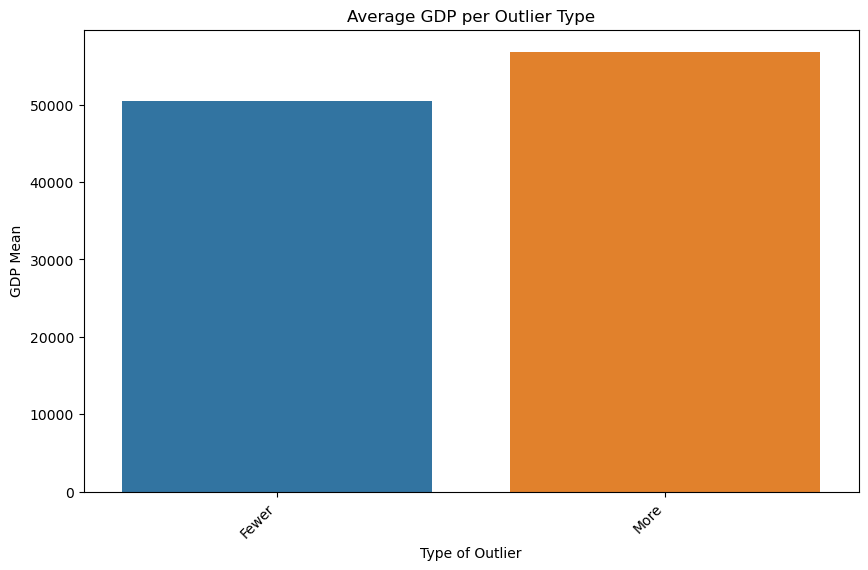

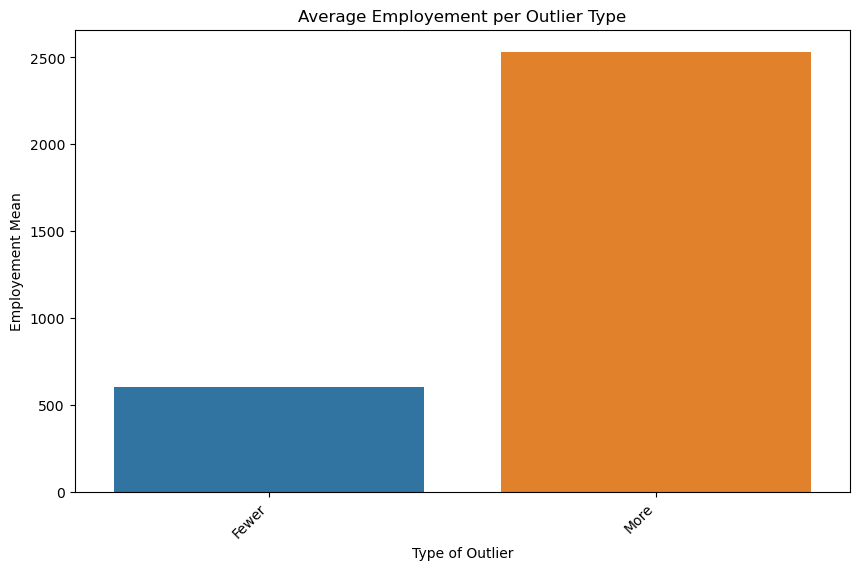

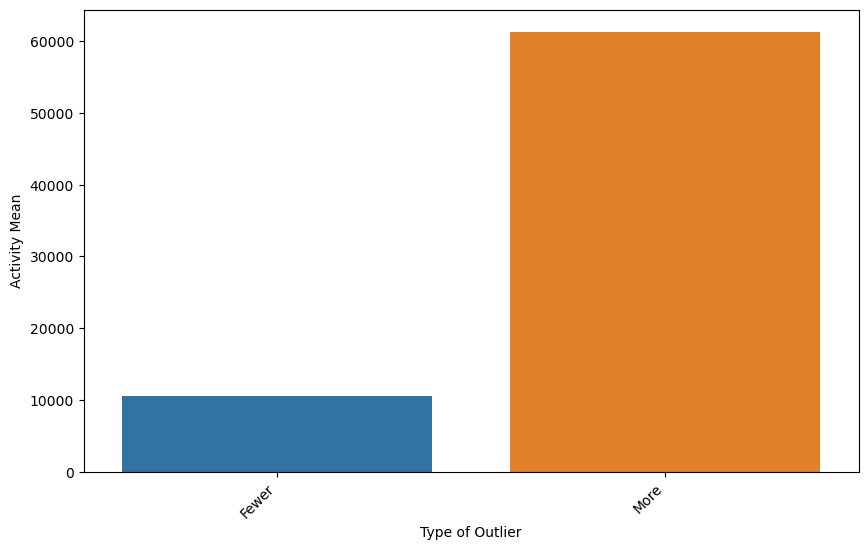

In [55]:
interpretation = outliers.groupby("interpretation").mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=interpretation.index, y=interpretation["GDP_per_cap"])
plt.title('Average GDP per Outlier Type')
plt.xlabel('Type of Outlier')
plt.ylabel('GDP Mean')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=interpretation.index, y=interpretation["EMP (THS)"])
plt.title('Average Employement per Outlier Type')
plt.xlabel('Type of Outlier')
plt.ylabel('Employement Mean')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=interpretation.index, y=interpretation["activity"])
plt.xlabel('Type of Outlier')
plt.ylabel('Activity Mean')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

The conclusion that the model consistently underestimates the target variable, especially when the initial (actual) value is much higher than the rest of the observations, implies that the model may not be capturing the full range or variability of the target variable. This pattern suggests that the model is systematically providing predictions that are lower than the true values, potentially indicating limitations in the model's complexity or the features considered.

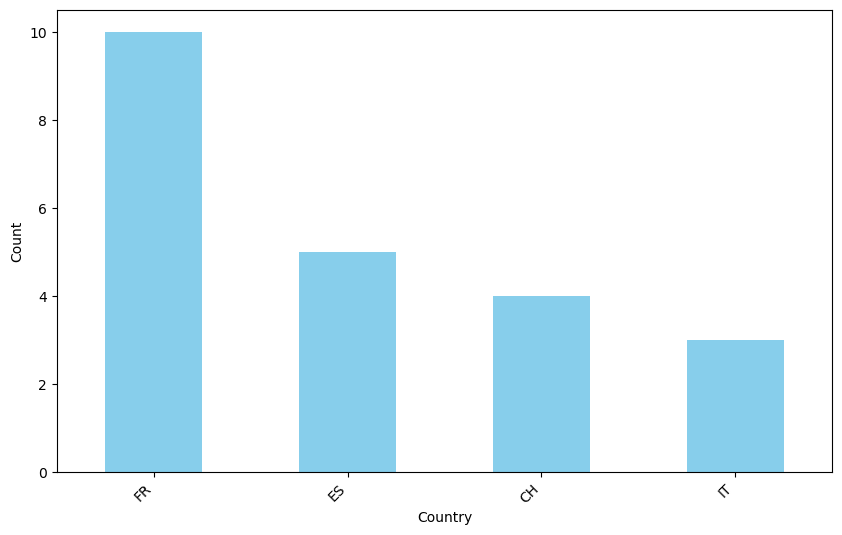

In [44]:
outliers_count_per_country = outlier.drop_duplicates(subset = ["nuts3_name"])
outliers_count = outliers_count_per_country['country'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
outliers_count.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


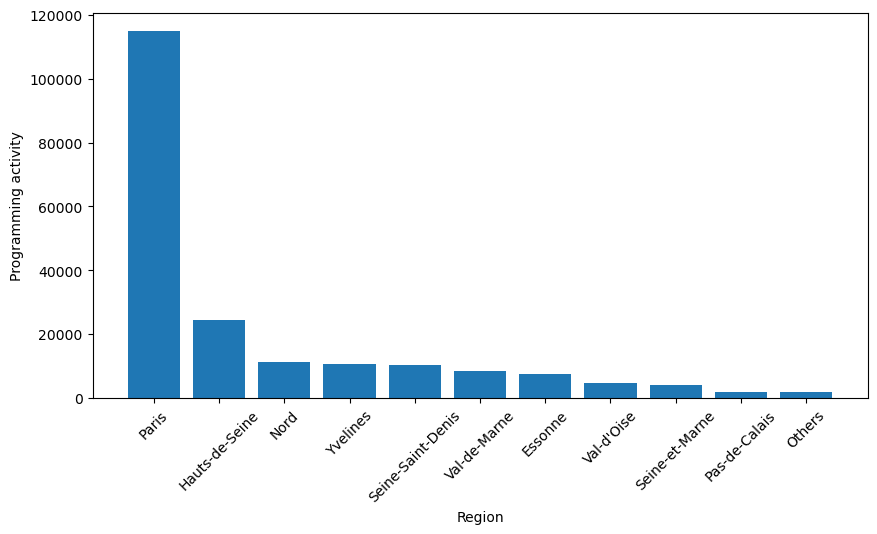

In [45]:
french_regions = outliers[outliers['country'] == 'FR']
sorted_french_regions = french_regions.sort_values(('activity'), ascending=False)

# Sort the French regions by 'GDP' and select the top 20
rest_french = df_years_growth[df_years_growth["country"] == "FR"]
rest_french_filtered = rest_french[~rest_french['nuts3_name'].isin(sorted_french_regions['nuts3_name'])]
rest_french_filtered = rest_french_filtered.groupby(["nuts3_name"], as_index=False).mean()

# Aggregate the remaining regions under "Others"
others = rest_french_filtered['activity'].mean()

data = {
    'nuts3_name': ['Others'],
    'activity': [others]
}

df = pd.DataFrame(data)
sorted_french_regions = sorted_french_regions[["nuts3_name", "activity"]]

# Append 'Others' to the DataFrame
top_french_regions_with_others = sorted_french_regions.append(df, ignore_index=True)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(top_french_regions_with_others['nuts3_name'], top_french_regions_with_others['activity'])
plt.xlabel('Region')
plt.ylabel('Programming activity')
plt.xticks(rotation=45)  # Rotate the x-axis labels to fit longer names
plt.show()

The provided table seems to represent programming literacy activity in different regions of France, with the 'nuts3_name' column indicating the region names and the 'activity' column containing corresponding values.

Here are some observations and analyses based on the table:

Paris Dominates Activity: The region with the highest programming literacy activity is Paris, with a significantly higher value (114794.15) compared to other regions. This suggests that Paris has a strong presence in programming literacy.

Significant Disparities: There are substantial differences in programming literacy activity between Paris and other regions. This indicates regional disparities in programming literacy initiatives or engagement.

Top Regions: After Paris, the regions of Hauts-de-Seine, Isère, and Val-de-Marne also show relatively high programming literacy activity. However, these values are much lower than Paris.

Contribution of Other Regions: The 'Others' category seems to represent the combined programming literacy activity of multiple regions. While individually these regions contribute less than the top ones, their collective contribution is notable.

Data Quality: It's important to consider the accuracy and completeness of the data. Ensure that the values are consistent with the metric used for programming literacy and that there are no missing or erroneous entries.

In conclusion, the analysis suggests a concentration of programming literacy activity in Paris, with other regions contributing to a lesser extent. Further exploration or context about the specific metric used for 'activity' and the goals of programming literacy initiatives in each region would provide a more comprehensive understanding.

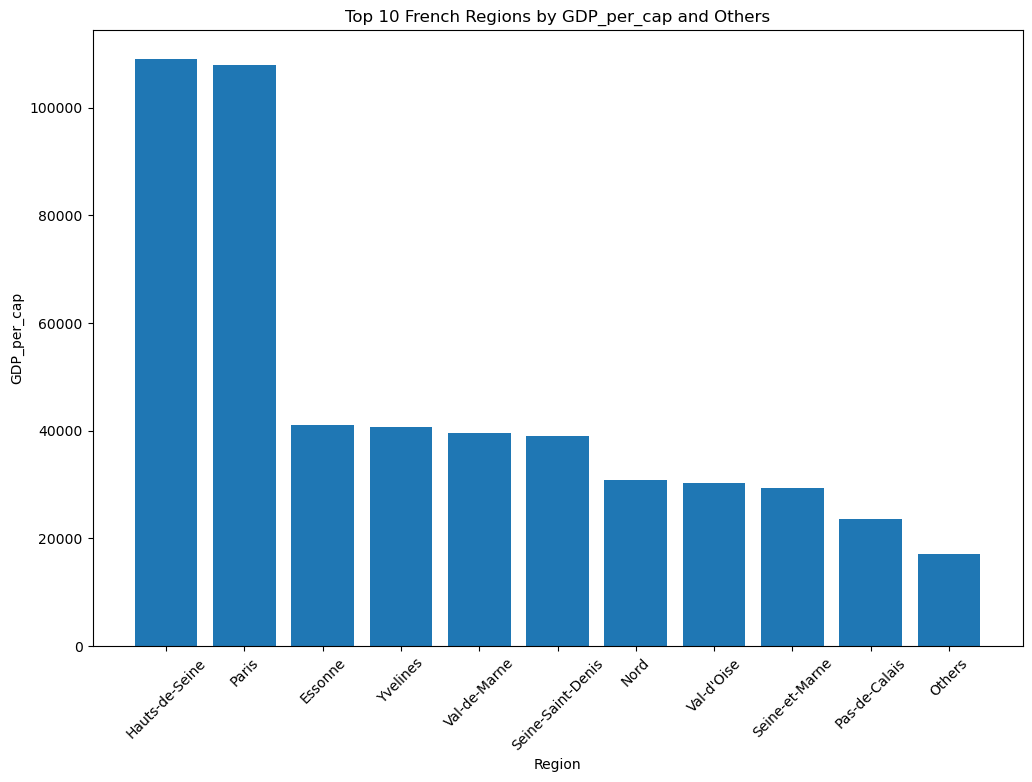

In [46]:
french_regions = outliers[outliers['country'] == 'FR']
sorted_french_regions = french_regions.sort_values(('GDP_per_cap'), ascending=False)

# Sort the French regions by 'GDP' and select the top 20
rest_french = df_years_growth[df_years_growth["country"] == "FR"]
rest_french_filtered = rest_french[~rest_french['nuts3_name'].isin(sorted_french_regions['nuts3_name'])]
rest_french_filtered = rest_french_filtered.groupby(["nuts3_name"], as_index=False).mean()

# Aggregate the remaining regions under "Others"
others = rest_french_filtered['GDP (MIO_EUR)'].mean()

data = {
    'nuts3_name': ['Others'],
    'GDP_per_cap': [others]
}

df = pd.DataFrame(data)
sorted_french_regions = sorted_french_regions[["nuts3_name", "GDP_per_cap"]]

# Append 'Others' to the DataFrame
top_french_regions_with_others = sorted_french_regions.append(df, ignore_index=True)

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.bar(top_french_regions_with_others['nuts3_name'], top_french_regions_with_others['GDP_per_cap'])
plt.xlabel('Region')
plt.ylabel('GDP_per_cap')
plt.title('Top 10 French Regions by GDP_per_cap and Others')
plt.xticks(rotation=45)
plt.show()

Paris has the Highest GDP: Similar to the programming literacy activity, Paris stands out with the highest GDP (234421.06 MIO_EUR). This indicates that Paris contributes significantly to the overall economic output in the regions considered.

Hauts-de-Seine is Second: Hauts-de-Seine follows Paris with a substantial GDP of 180605.06 MIO_EUR. Together with Paris, these two regions contribute significantly to the total economic output.

Comparison with Programming Literacy: Comparing this GDP table with the programming literacy activity table, you can observe that regions with higher GDP, like Paris and Hauts-de-Seine, also tend to have higher programming literacy activity. This correlation might suggest a potential link between economic prosperity and investment or engagement in programming literacy initiatives.

Bouches-du-Rhône and Val-de-Marne: These regions have relatively high GDP values, indicating significant economic activity. When compared to the programming literacy activity, it's interesting to explore whether there's a similar correlation in these regions.

Others Category: The 'Others' category in both tables represents a combined value for multiple regions. It's important to further investigate the individual regions contributing to this category and understand their specific economic and programming literacy characteristics.

In summary, the GDP table provides insights into the economic output of different regions, and when compared with the programming literacy activity, it allows for a broader understanding of the relationship between economic prosperity and engagement in programming literacy initiatives across various regions in France.

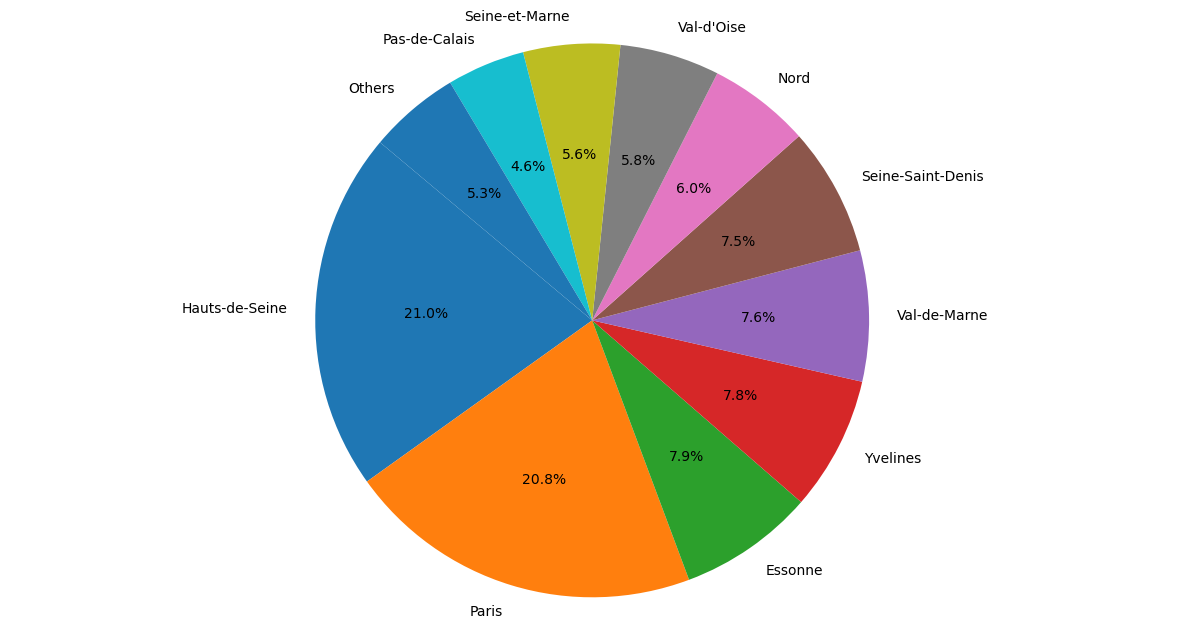

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'outliers' and 'df_years_growth' are your DataFrames

# Select the French regions
french_regions = outliers[outliers['country'] == 'FR']
sorted_french_regions = french_regions.sort_values('GDP_per_cap', ascending=False)

# Sort the French regions by 'GDP' and select the top 10
rest_french = df_years_growth[df_years_growth["country"] == "FR"]
rest_french_filtered = rest_french[~rest_french['nuts3_name'].isin(sorted_french_regions['nuts3_name'])]
rest_french_filtered = rest_french_filtered.groupby("nuts3_name", as_index=False).mean()

# Aggregate the remaining regions under "Others"
others = rest_french_filtered['GDP_per_cap'].mean()

data = {
    'nuts3_name': ['Others'],
    'GDP_per_cap': [others]
}

df = pd.DataFrame(data)
sorted_french_regions = sorted_french_regions[["nuts3_name", "GDP_per_cap"]]

# Append 'Others' to the DataFrame
top_french_regions_with_others = sorted_french_regions.append(df, ignore_index=True)

# Create the pie chart
plt.figure(figsize=(15, 8))
plt.pie(top_french_regions_with_others['GDP_per_cap'], labels=top_french_regions_with_others['nuts3_name'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Arima 

In [ ]:
outliers.index

In [ ]:
# Extract time series for 'Alpes-Maritimes'
alpes_maritimes = df[(df["nuts3_name"] == "Alpes-Maritimes")]
alpes_maritimes_gdp = alpes_maritimes['GDP_per_cap']
alpes_maritimes.columns

In [ ]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller_test(series):
    result = adfuller(series.dropna()) # Drop NaN values if any
    print(f'Results for {series.name}:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Perform test for 'Alpes-Maritimes'
perform_adfuller_test(alpes_maritimes_gdp)

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Define your dataframe (df), outliers, and factors
outliers = ['Alpes-Maritimes', 'Balearic Islands', 'Barcelona', 'Bouches-du-Rhône',
       'Florence', 'Hauts-de-Seine', 'Isère', 'Madrid', 'Milan', 'Paris',
       'Rome', 'Seine-et-Marne', 'Skåne County', 'Stockholm County',
       'Val-de-Marne', 'Vaud', 'Västra Götaland County', 'Zürich'] 
factors = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', 'POP (THS)', 'activity',
       'activity_per_cap', 'CAGR', 'CAGR_per_cap', 'experts', 'innovators',
       'late_adopters', 'programmers_total', 'programmer_density',
       'GDP_per_cap', 'EMP_per_cap']

# Function to perform Augmented Dickey-Fuller test
def perform_adfuller_test(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

# Dictionary to store results
stationarity_results = {}

# Iterate over each outlier and factor
for outlier in outliers:
    stationarity_results[outlier] = {}
    for factor in factors:
        # Extract the time series data for the factor
        time_series = df[df['nuts3_name'] == outlier][factor]
        # Perform the stationarity test
        stationarity_results[outlier][factor] = perform_adfuller_test(time_series)

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(stationarity_results).T

In [ ]:
# Adding a summary flag
for outlier in stationarity_results:
    for factor in stationarity_results[outlier]:
        result = stationarity_results[outlier][factor]
        if result['p-value'] < 0.05 and result['ADF Statistic'] < result['Critical Values']['5%']:
            summary_flag = 'Stationary'
        else:
            summary_flag = 'Non-stationary'
        stationarity_results[outlier][factor]['Summary'] = summary_flag

# Update DataFrame
results_df = pd.DataFrame(stationarity_results).T

# Summary Report
summary_counts = results_df.applymap(lambda x: x.get('Summary') if isinstance(x, dict) else None)
summary_report = summary_counts.apply(pd.Series.value_counts).T
summary_report.fillna(0, inplace=True)

print(summary_report)

- A significant number of regions showed non-stationarity in economic indicators like GDP (MIO_EUR) and GVA (MIO_EUR).

#### ARIMA TIME SERIES for stationarity 
The model will be based on the factors' mean values as we have limited amount of data to work with yearly values. 

We will filter for statistically significant values. By filtering for p-values less than 0.05 helps to ensure that the factors that we use to make predictions are truly relevant.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Define outliers, and factors
outliers = ['Alpes-Maritimes', 'Balearic Islands', 'Barcelona', 'Bouches-du-Rhône',
       'Florence', 'Hauts-de-Seine', 'Isère', 'Madrid', 'Milan', 'Paris',
       'Rome', 'Seine-et-Marne', 'Skåne County', 'Stockholm County',
       'Val-de-Marne', 'Vaud', 'Västra Götaland County', 'Zürich'] 
factors = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', 'POP (THS)', 'activity',
       'activity_per_cap', 'CAGR', 'CAGR_per_cap', 'experts', 'innovators',
       'late_adopters', 'programmers_total', 'programmer_density',
       'GDP_per_cap', 'EMP_per_cap']


significant_results = {}

# Iterate over each outlier
for outlier in outliers:
    time_series = df[df['nuts3_name'] == outlier][factor].dropna()
    
    # Fit ARIMA Model (example: ARIMA(1, 1, 1))
    model = ARIMA(time_series, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Extract p-values and filter
    pvalues = model_fit.pvalues
    significant_params = pvalues[pvalues < 0.05]
    
    # Store significant results
    significant_results[outlier] = significant_params

# Convert results to DataFrame for easy viewing
significant_df = pd.DataFrame(significant_results)

# Display significant results
significant_df

For Nans, ARIMA model did not find significant patterns in the time series data.
Those regions might require a different modeling approach or additional data preprocessing. Or it is due to not enough values for creating a model.

In [ ]:
# Store significant p-values and ARIMA model summaries
significant_pvalues = {}
arima_summaries = {}

# Iterate over each outlier and factor
for outlier in outliers:
    for factor in factors:
        # Extract the time series data for the factor
        time_series = df[df['nuts3_name'] == outlier][factor].dropna()
        
        # Proceed only if there's enough data
        if len(time_series) > 5:
            try:
                # Fit ARIMA Model (example: ARIMA(1, 1, 1))
                model = ARIMA(time_series, order=(1, 1, 1))
                model_fit = model.fit()
                
                # Extract p-values and filter
                pvalues = model_fit.pvalues
                significant_params = pvalues[pvalues < 0.05]
                
                # Store significant results
                if not significant_params.empty:
                    significant_pvalues[f'{outlier} - {factor}'] = significant_params
                    
                    # Plot PACF
                    plt.figure(figsize=(10, 6))
                    plot_pacf(time_series, lags=5)
                    plt.title(f'Partial Autocorrelation for {outlier} - {factor}')
                    plt.show()

                    # Store ARIMA model summaries
                    arima_summaries[f'{outlier} - {factor}'] = model_fit.summary()
                    
            except Exception as e:
                print(f"Model failed to fit for {outlier} - {factor}: {e}")

# Convert results to DataFrame for easy viewing
significant_pvalues_df = pd.DataFrame(significant_pvalues)

# Print results
for key, summary in arima_summaries.items():
    print(f'ARIMA Model Summary for {key}:\n{summary}\n\n')

significant_pvalues_df

- For regions like Alpes-Maritimes and others where the ARIMA model did not find significant patterns, this would imply that the time series data for these regions do not have patterns that the model could learn.
- Rome and the Balearic Islands, where the ARIMA model identified significant patterns, could lead to more accurate predictions. These regions showed significant values in the ARIMA model parameters, suggesting that their past data can provide insights for future predictions.

So for predictive model, we can include both regions for predictiving programming density

#### Plotting non stationary regions 

In [ ]:
# Extract time series
balearic_islands = df[(df["nuts3_name"] == "Balearic Islands")]
balearic_islands.columns

In [ ]:
# Plotting multiple series in one plot
plt.figure(figsize=(12, 6))

#plt.plot(balearic_islands['year'], balearic_islands['GDP (MIO_EUR)'], label='GDP (MIO_EUR)')
plt.plot(balearic_islands['year'], balearic_islands['experts'], label='Experts')
plt.plot(balearic_islands['year'], balearic_islands['innovators'], label='Innovators')
plt.plot(balearic_islands['year'], balearic_islands['late_adopters'], label='Late Adopters')
plt.plot(balearic_islands['year'], balearic_islands['programmers_total'], label='Total Programmers')
plt.plot(balearic_islands['year'], balearic_islands['programmer_density'], label='Programmer Density')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Time Series Analysis for Balearic Islands (2008-2020)')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(balearic_islands['year'], balearic_islands['GDP_per_cap'], label='GDP per Capita')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Time Series Analysis for Balearic Islands (2008-2020)')
plt.legend()
plt.show()

In [ ]:
rome = df[(df["nuts3_name"] == "Rome")]

# Plotting multiple series in one plot
plt.figure(figsize=(12, 6))

# Replace 'year' with your actual year column name
# Replace factor names with the actual column names in your DataFrame
plt.plot(rome['year'], rome['experts'], label='Experts')
plt.plot(rome['year'], rome['innovators'], label='Innovators')
plt.plot(rome['year'], rome['late_adopters'], label='Late Adopters')
plt.plot(rome['year'], rome['programmers_total'], label='Total Programmers')
plt.plot(rome['year'], rome['programmer_density'], label='Programmer Density')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Time Series Analysis for Rome (2008-2020)')
plt.legend()
plt.show()

In [ ]:
plt.plot(rome['year'], rome['GDP_per_cap'], label='GDP per Capita')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Time Series Analysis for Rome (2008-2020)')
plt.legend()
plt.show()

Both Balearic Islands and Rome have some sort of non stationary changes, this could have influenced the results on the proedictive model and perhaps by removing both regions, the model could benefit.